# Bump Hunt with baseline features and BDT setup

For these plots, a bump hunt is performed with the original LHCO R&D dataset only. Sliding windows are all 0.4TeV wide and move by 0.1TeV. These runs use k-fold cross validation at k=5. 

The systematics are estimated as 
\begin{equation}
    \mathcal{S}= \frac{N'-\varepsilon_B (1+\alpha) N_{SR}}{\sqrt{\sigma_{stat}^2+\sigma_{sys}^2}}
\end{equation}
where $\alpha$ is a relative systematic offset caused by the systematic differences between CR and SR bkg.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BH_percentiles = [1e-2, 1e-3, 1e-4]
general_directory = "/hpcwork/zu992399/bumphunt_paper/"
plotting_direc = "plots/extended/"

In [3]:
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['font.serif'] = []
#plt.rcParams['text.usetex'] = True
#plt.rcParams['figure.figsize'] = 3.5, 2.625
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['errorbar.capsize'] = 2
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16 
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 12
#plt.rcParams['legend.frameon'] = True

In [4]:
def calc_and_apply_threshold(samples_preds, data_preds, labels, efficiency):
    eps = np.quantile(samples_preds, 1-efficiency, method="lower")
    if efficiency == 1:
        eps=0.
    N_samples_after = np.size(np.where(samples_preds>=eps))
    N_samples = len(samples_preds)
    N_after = np.size(np.where(data_preds>=eps))#-1/3
    N = len(data_preds)
    N_bkg = np.size(np.where(data_preds[labels==0]>eps))
    N_sig = np.size(np.where(data_preds[labels==1]>eps))
    return N_samples_after, N_samples, N_after, N, N_bkg, N_sig

def formula_significance(s, b, sigma):
    N = s+b
    Z = N*np.log(N*(b+sigma**2)/(b**2+N*sigma**2))-b**2/sigma**2*np.log(1+sigma**2*s/b/(b+sigma**2))
    return np.sqrt(2*Z)
    
def test_significances(N_after, N, N_sig, N_bkg, eff, err, cwola):
    b = (1+err)*N*eff
    s = N_after-(1+err)*N*eff
    if cwola:
        results = formula_significance(N_after-N*eff,N*eff,np.sqrt(2*N*eff))
        rel_results = formula_significance(N_after-(1+err)*N*eff, (1+err)*N*eff, np.sqrt(eff*N*2+(eff*err*N)**2))
        true_results = N_sig/np.sqrt(N_bkg*2)
    else:
        results = formula_significance(N_after-N*eff,N*eff,np.sqrt(N*eff))
        rel_results = formula_significance(N_after-(1+err)*N*eff, (1+err)*N*eff, np.sqrt(eff*N+(eff*err*N)**2))
        true_results = N_sig/np.sqrt(N_bkg)
    rel_error = (N_after-N*eff)/(eff*N)
    return results, rel_results, true_results, rel_error
    
    
def significances(N_after, N, N_sig, N_bkg, eff, err, cwola):
    if cwola: 
        results = (N_after-N*eff)/np.sqrt(eff*N*2)
        rel_results = (N_after-(1+err)*N*eff)/np.sqrt(eff*N*2+(eff*err*N)**2)
        true_results = N_sig/np.sqrt(N_bkg*2)
    else: 
        results = (N_after-N*eff)/np.sqrt(eff*N)
        rel_results = (N_after-(1+err)*N*eff)/np.sqrt(eff*N+(eff*err*N)**2)
        true_results = N_sig/np.sqrt(N_bkg)
    rel_error = (N_after-N*eff)/(eff*N)
    return results, rel_results, true_results, rel_error

In [5]:
def bump_hunt_single_window(folder, cwola, window, err=None, runs=10, turn_around=False):
	results = np.zeros((len(BH_percentiles),runs))
	true_results =  np.zeros((len(BH_percentiles),runs))
	rel_results =  np.zeros((len(BH_percentiles),runs))
	rel_error =  np.zeros((len(BH_percentiles),runs))

	arr_shape = (5,len(BH_percentiles), runs)
	N_samples_after = np.zeros(arr_shape)
	N_samples = np.zeros(arr_shape)
	N_after = np.zeros(arr_shape)
	N = np.zeros(arr_shape)
	N_bkg = np.zeros(arr_shape)
	N_sig = np.zeros(arr_shape)
	N_bkg_orig = 0

	for fold in range(5): 
		f = folder +"fold"+str(fold)+"/"
		if turn_around: 
			samples_preds = np.load(f+"test_preds.npy")
			data_preds = np.load(f+"samples_preds.npy")
			labels = np.zeros((data_preds.shape[1]))
		else:
			samples_preds = np.load(f+"samples_preds.npy")
			data_preds = np.load(f+"test_preds.npy")
			labels = np.load(f+"Y_test.npy")
		N_bkg_orig += np.shape(data_preds[:,labels==0])[-1]
		for j, perc in enumerate(BH_percentiles):
			for i in range(len(samples_preds)):
				N_samples_after[fold, j, i], N_samples[fold, j, i], N_after[fold, j, i], N[fold, j, i], N_bkg[fold, j, i], N_sig[fold, j, i] = calc_and_apply_threshold(samples_preds[i], data_preds[i], labels, perc)
	N_samples_after = np.sum(N_samples_after, axis=0)
	N_samples = np.sum(N_samples, axis=0)
	N_after = np.sum(N_after, axis=0)
	N = np.sum(N, axis=0)
	N_bkg = np.sum(N_bkg, axis=0)
	N_sig = np.sum(N_sig, axis=0)
	eff_eff = N_samples_after/N_samples

	if err is None:
		err = np.zeros(len(BH_percentiles))
		
	for j, perc in enumerate(BH_percentiles):
		results[j], rel_results[j], true_results[j], rel_error[j] = significances(N_after[j], N[j], N_sig[j], N_bkg[j], eff_eff[j], err[j], cwola)

	return results, rel_results, true_results, rel_error

def bump_hunt(folder, cwola, err=None, runs=10, turn_around=False):
	print(folder)

	results = np.zeros((len(BH_percentiles),9,runs))
	true_results =  np.zeros((len(BH_percentiles),9,runs))
	rel_results =  np.zeros((len(BH_percentiles),9,runs))
	rel_error =  np.zeros((len(BH_percentiles),9,runs))

	for window in range(9):
		results[:,window], rel_results[:,window], true_results[:,window], rel_error[:,window] = bump_hunt_single_window(folder+"window"+str(window+1)+"_", cwola, window, err=err, runs=runs, turn_around=turn_around)
	
	return results, rel_results, true_results, rel_error

In [6]:
colors_results = ["blue", "red", "orange"]
#colors_true = ["dodgerblue", "orange", "lilac"]

def plotting(rel_results, true_results, name):
    plt.figure()
    x = range(1,10)
    plt.axhline(5, color="black", linestyle="--", label="5$\sigma$")
    plt.axhline(0, color="black", label="0$\sigma$")
    for j, perc in enumerate(BH_percentiles):
        plt.errorbar(x, np.mean(rel_results[j],axis=-1), yerr = np.std(rel_results[j], axis=-1,ddof=1), label=r"$\epsilon_B$="+str(perc), fmt='o', color=colors_results[j])
        #plt.errorbar(x, np.mean(true_results[j],axis=-1), yerr = np.std(rel_results[j], axis=-1,ddof=1), fmt='o', color=colors_true[j])
        
    plt.grid()
    plt.ylabel(r"Deviation")
    plt.xlabel(r"Sliding window #")
    plt.legend()
    plt.subplots_adjust(bottom=0.15, left= 0.19, top = 0.92, right = 0.965)

    plt.savefig(plotting_direc+name+".pdf")
    plt.savefig(plotting_direc+name+".png")


## CWoLa

First, the systematic offset is determined as a constant relative offset in $m_{JJ}$ with 
\begin{equation}
    \alpha = \frac{N'-\varepsilon_B N_{SR}}{\varepsilon_B N_{SR}}
\end{equation}
based on 10 runs without signal.

We estimate our systematic error conservatively with $\sigma_{sys}=\alpha\varepsilon_B N_{SR}.$ 

/hpcwork/zu992399/bumphunt_paper/cwola_extended1_without/
/hpcwork/zu992399/bumphunt_paper/cwola_extended1_without/
alpha = [0.1240656  0.17049959 0.17331013]


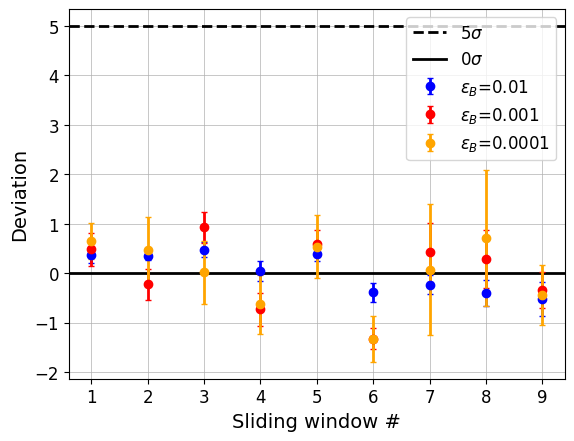

In [9]:
folder = general_directory+"cwola_extended1_without/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True)
cwola_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=np.mean(rel_error,axis=(1,2)))
plotting(rel_results, true_results, "cwola_extended1_without")
print("alpha =",cwola_error)

We test our systematic error by considering 100 independent runs (on the same dataset).

Results show a good agreement with the null hypothesis with a slightly overestimated error that is in the correct order of magnitude.

We now look at an analysis with signal: 

/hpcwork/zu992399/bumphunt_paper/cwola_extended1_norm/


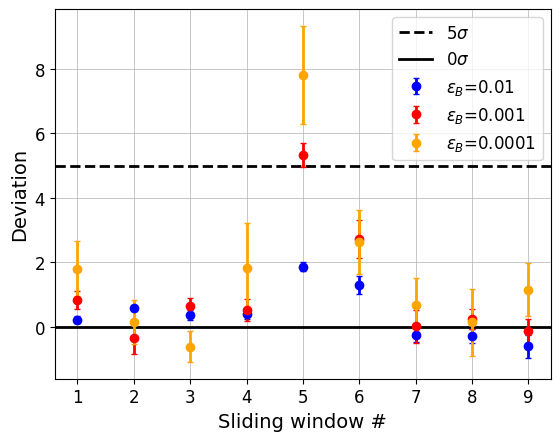

In [10]:
folder = general_directory+"cwola_extended1_norm/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=cwola_error)
plotting(rel_results, true_results, "cwola_extended1_norm")

/hpcwork/zu992399/bumphunt_paper/cwola_extended2_without/
/hpcwork/zu992399/bumphunt_paper/cwola_extended2_without/
alpha = [0.14085159 0.14206112 0.14473863]


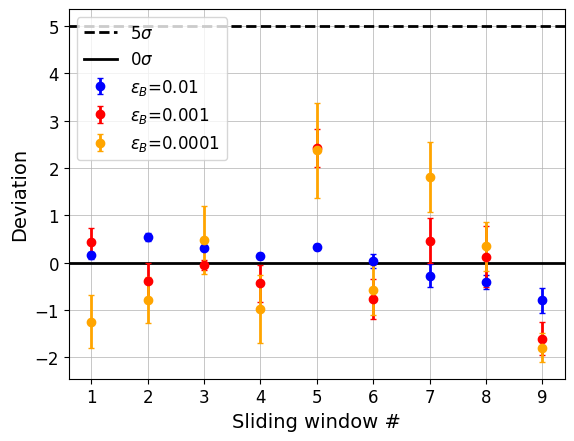

In [11]:
folder = general_directory+"cwola_extended2_without/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True)
cwola_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=np.mean(rel_error,axis=(1,2)))
plotting(rel_results, true_results, "cwola_extended2_without")
print("alpha =",cwola_error)

/hpcwork/zu992399/bumphunt_paper/cwola_extended2_norm/


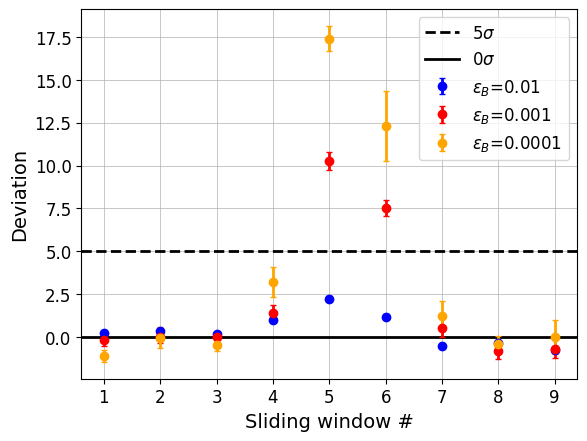

In [12]:
folder = general_directory+"cwola_extended2_norm/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=cwola_error)
plotting(rel_results, true_results, "cwola_extended2_norm")

/hpcwork/zu992399/bumphunt_paper/cwola_extended3_without/
/hpcwork/zu992399/bumphunt_paper/cwola_extended3_without/
alpha = [0.23042601 0.14528647 0.02833423]


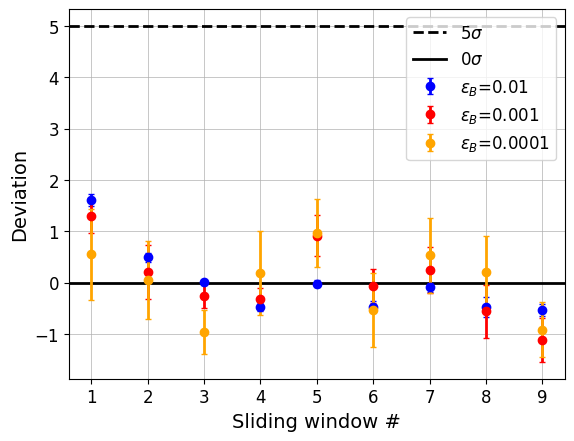

In [7]:
folder = general_directory+"cwola_extended3_without/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True)
cwola_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=np.mean(rel_error,axis=(1,2)))
plotting(rel_results, true_results, "cwola_extended3_without")
print("alpha =",cwola_error)

/hpcwork/zu992399/bumphunt_paper/cwola_extended3_norm/


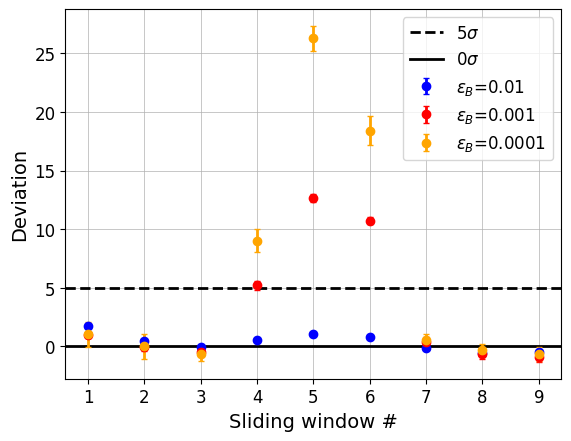

In [8]:
folder = general_directory+"cwola_extended3_norm/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=cwola_error)
plotting(rel_results, true_results, "cwola_extended3_norm")

## CATHODE

We now perform the same analysis for CATHODE. We do not rerun the DE for different runs. First 10 runs without signal to estimate the systematic offset and error.

/hpcwork/zu992399/bumphunt_paper/cathode_without_DE2/
/hpcwork/zu992399/bumphunt_paper/cathode_without_DE2/
alpha =  [0.21589423 0.3798406  0.9270578 ]


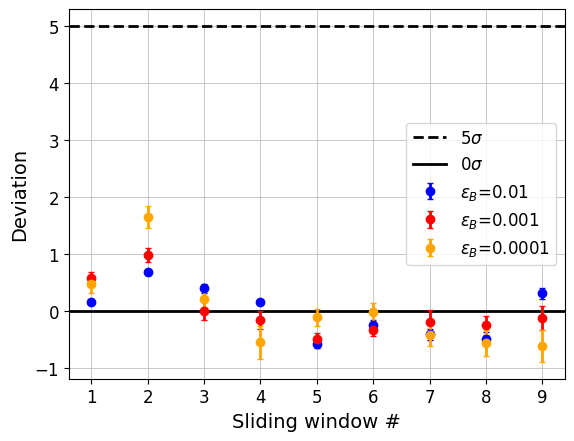

In [24]:
folder = general_directory+"cathode_without_DE2/"
results, rel_results, true_results, rel_error = bump_hunt(folder, False)
cathode_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, False, err=cathode_error)
plotting(rel_results, true_results, "cathode_without")
print("alpha = ", cathode_error)

/hpcwork/zu992399/bumphunt_paper/cathode_norm_DE2/


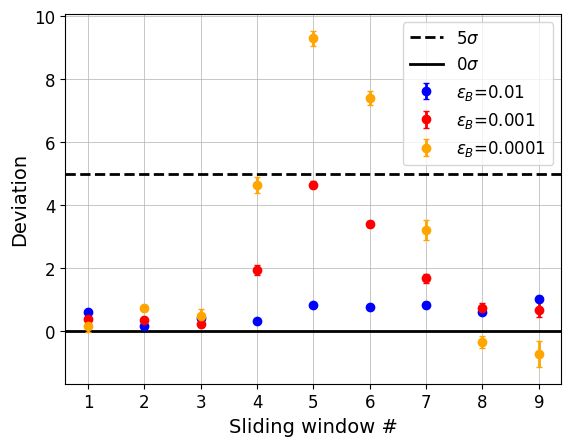

In [25]:
folder = general_directory+"cathode_norm_DE2/"
results, rel_results, true_results, rel_error = bump_hunt(folder, False, err=cathode_error)
plotting(rel_results, true_results, "cathode_norm")

/hpcwork/zu992399/bumphunt_paper/cathode_extended1_without_ranit/
/hpcwork/zu992399/bumphunt_paper/cathode_extended1_without_ranit/
alpha =  [0.1596486  0.33073466 1.14875505]


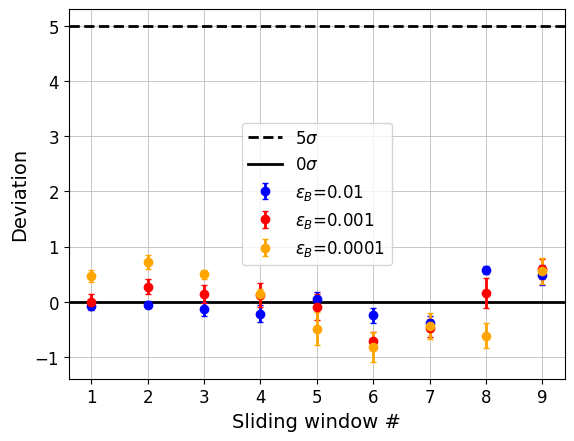

In [8]:
folder = general_directory+"cathode_extended1_without_ranit/"
results, rel_results, true_results, rel_error = bump_hunt(folder, False)
cathode_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, False, err=cathode_error)
plotting(rel_results, true_results, "cathode_without")
print("alpha = ", cathode_error)

/hpcwork/zu992399/bumphunt_paper/cathode_extended1_norm_ranit/


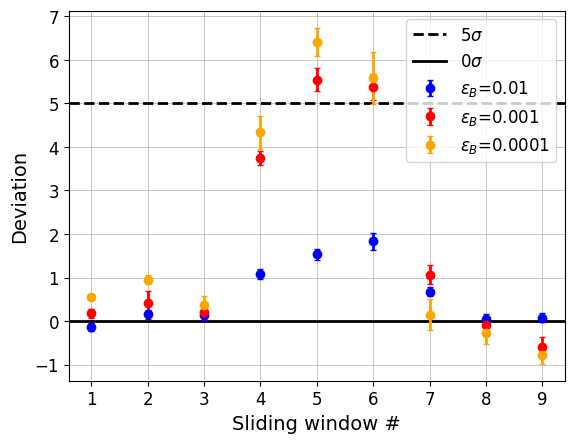

In [9]:
folder = general_directory+"cathode_extended1_norm_ranit/"
results, rel_results, true_results, rel_error = bump_hunt(folder, False, err=cathode_error)
plotting(rel_results, true_results, "cathode_norm")

/hpcwork/zu992399/bumphunt_paper/cathode_extended2_without_ranit/
/hpcwork/zu992399/bumphunt_paper/cathode_extended2_without_ranit/
alpha =  [0.14956349 0.21925437 0.22601712]


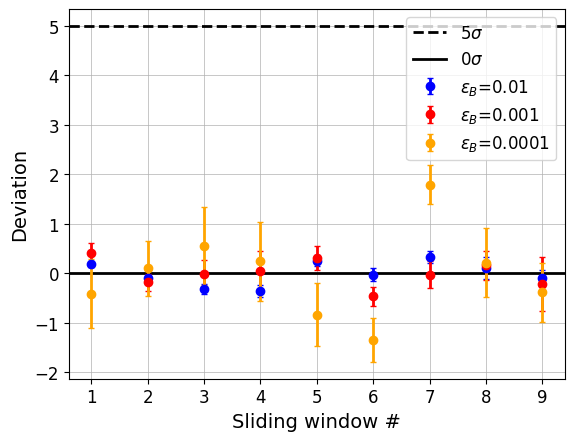

In [7]:
folder = general_directory+"cathode_extended2_without_ranit/"
results, rel_results, true_results, rel_error = bump_hunt(folder, False)
cathode_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, False, err=cathode_error)
plotting(rel_results, true_results, "cathode_without")
print("alpha = ", cathode_error)

/hpcwork/zu992399/bumphunt_paper/cathode_extended2_norm_ranit/


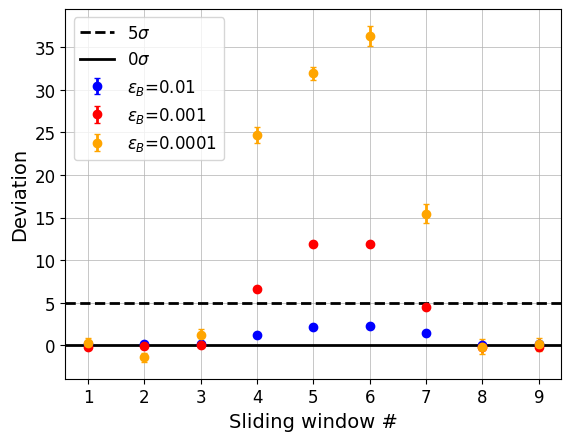

In [8]:
folder = general_directory+"cathode_extended2_norm_ranit/"
results, rel_results, true_results, rel_error = bump_hunt(folder, False, err=cathode_error)
plotting(rel_results, true_results, "cathode_norm")

/hpcwork/zu992399/bumphunt_paper/cathode_extended3_without_ranit/
/hpcwork/zu992399/bumphunt_paper/cathode_extended3_without_ranit/
alpha =  [0.51925889 2.30511519 6.60824371]


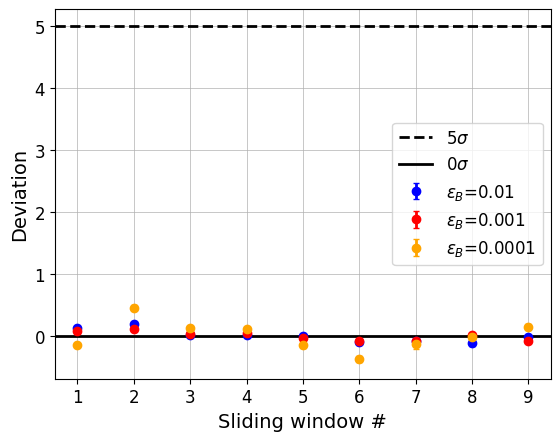

In [7]:
folder = general_directory+"cathode_extended3_without_ranit/"
results, rel_results, true_results, rel_error = bump_hunt(folder, False)
cathode_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, False, err=cathode_error)
plotting(rel_results, true_results, "cathode_without")
print("alpha = ", cathode_error)

/hpcwork/zu992399/bumphunt_paper/cathode_extended3_norm_ranit/


/tmp/zu992399/login18-3_61744/ipykernel_162940/2705642378.py:36: RuntimeWarning: invalid value encountered in true_divide
  eff_eff = N_samples_after/N_samples
/tmp/zu992399/login18-3_61744/ipykernel_162940/636369477.py:41: RuntimeWarning: invalid value encountered in true_divide
  true_results = N_sig/np.sqrt(N_bkg)


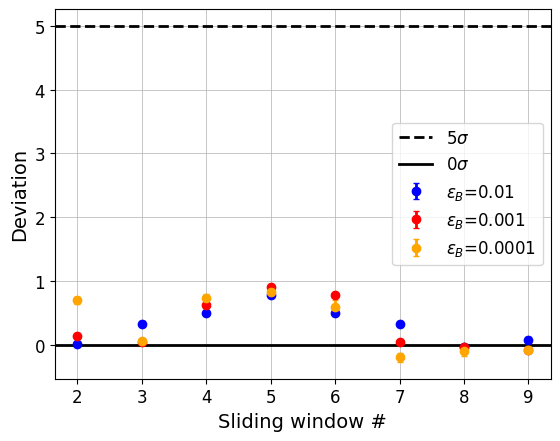

In [8]:
folder = general_directory+"cathode_extended3_norm_ranit/"
results, rel_results, true_results, rel_error = bump_hunt(folder, False, err=cathode_error)
plotting(rel_results, true_results, "cathode_norm")

/hpcwork/zu992399/bumphunt_paper/cathode_without_extended1/


/tmp/zu992399/login18-3_127450/ipykernel_128274/636369477.py:41: RuntimeWarning: invalid value encountered in true_divide
  true_results = N_sig/np.sqrt(N_bkg)


/hpcwork/zu992399/bumphunt_paper/cathode_without_extended1/
alpha =  [0.36903897 0.65405135 1.29313257]


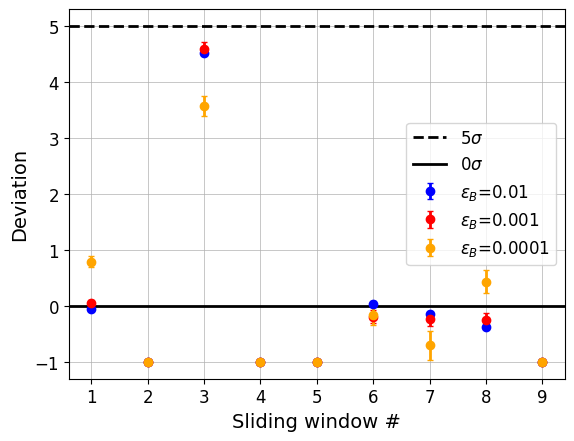

In [7]:
folder = general_directory+"cathode_without_extended1/"
results, rel_results, true_results, rel_error = bump_hunt(folder, False)
cathode_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, False, err=cathode_error)
plotting(rel_results, true_results, "cathode_without")
print("alpha = ", cathode_error)

/hpcwork/zu992399/bumphunt_paper/cathode_norm_extended1/


/tmp/zu992399/login18-3_127450/ipykernel_128274/636369477.py:41: RuntimeWarning: invalid value encountered in true_divide
  true_results = N_sig/np.sqrt(N_bkg)


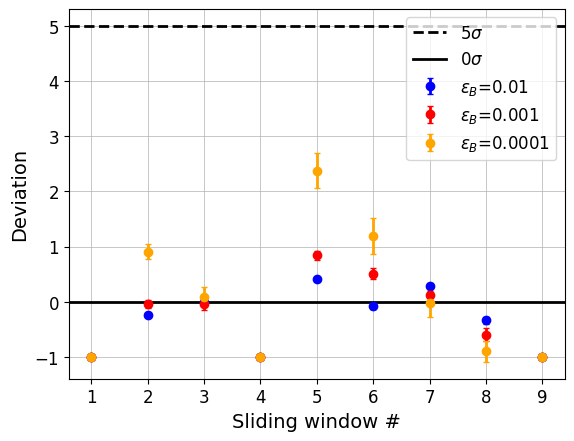

In [8]:
folder = general_directory+"cathode_norm_extended1/"
results, rel_results, true_results, rel_error = bump_hunt(folder, False, err=cathode_error)
plotting(rel_results, true_results, "cathode_norm")

/hpcwork/zu992399/bumphunt_paper/cathode_without_extended2/


/tmp/zu992399/login18-3_127450/ipykernel_128274/636369477.py:41: RuntimeWarning: invalid value encountered in true_divide
  true_results = N_sig/np.sqrt(N_bkg)


/hpcwork/zu992399/bumphunt_paper/cathode_without_extended2/
alpha =  [0.33834568 0.7090009  1.0595277 ]


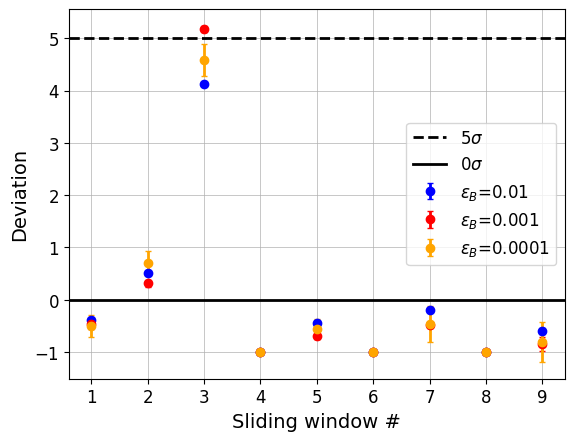

In [9]:
folder = general_directory+"cathode_without_extended2/"
results, rel_results, true_results, rel_error = bump_hunt(folder, False)
cathode_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, False, err=cathode_error)
plotting(rel_results, true_results, "cathode_without")
print("alpha = ", cathode_error)

/hpcwork/zu992399/bumphunt_paper/cathode_without_extended3/


/tmp/zu992399/login18-3_127450/ipykernel_128274/636369477.py:41: RuntimeWarning: invalid value encountered in true_divide
  true_results = N_sig/np.sqrt(N_bkg)


/hpcwork/zu992399/bumphunt_paper/cathode_without_extended3/
alpha =  [0. 0. 0.]


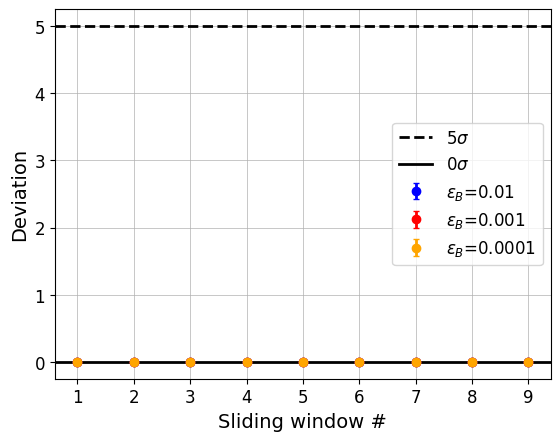

In [10]:
folder = general_directory+"cathode_without_extended3/"
results, rel_results, true_results, rel_error = bump_hunt(folder, False)
cathode_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, False, err=cathode_error)
plotting(rel_results, true_results, "cathode_without")
print("alpha = ", cathode_error)

/hpcwork/zu992399/bumphunt_paper/cathode_norm_extended3/


/tmp/zu992399/login18-3_127450/ipykernel_128274/636369477.py:41: RuntimeWarning: invalid value encountered in true_divide
  true_results = N_sig/np.sqrt(N_bkg)


/hpcwork/zu992399/bumphunt_paper/cathode_norm_extended3/
alpha =  [0. 0. 0.]


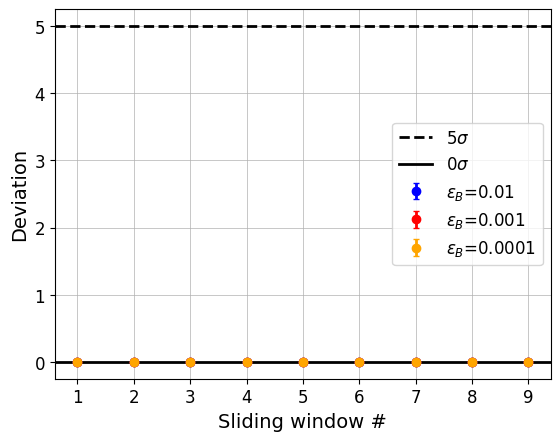

In [11]:
folder = general_directory+"cathode_norm_extended3/"
results, rel_results, true_results, rel_error = bump_hunt(folder, False)
cathode_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, False, err=cathode_error)
plotting(rel_results, true_results, "cathode_without")
print("alpha = ", cathode_error)

# HERWIG

/hpcwork/zu992399/bumphunt_paper/cwola_herwig_without_2/
/hpcwork/zu992399/bumphunt_paper/cwola_herwig_without_2/
alpha = [0.13959993 0.11007428 0.04262035]


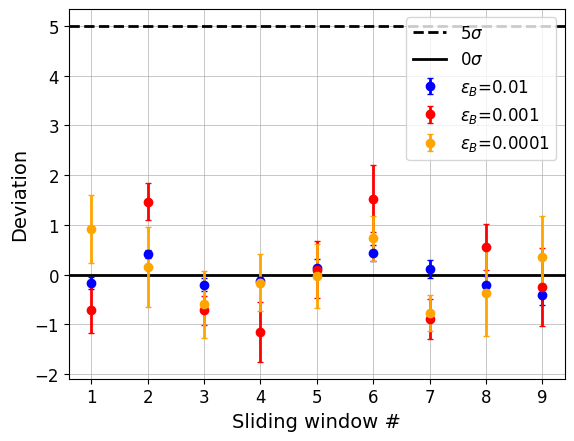

In [8]:
folder = general_directory+"cwola_herwig_without_2/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True)
cwola_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=np.mean(rel_error,axis=(1,2)))
plotting(rel_results, true_results, "cwola_herwig_baseline_without")
print("alpha =",cwola_error)

/hpcwork/zu992399/bumphunt_paper/cwola_herwig_extended1_without/
/hpcwork/zu992399/bumphunt_paper/cwola_herwig_extended1_without/
alpha = [0.12584789 0.16117784 0.21798956]


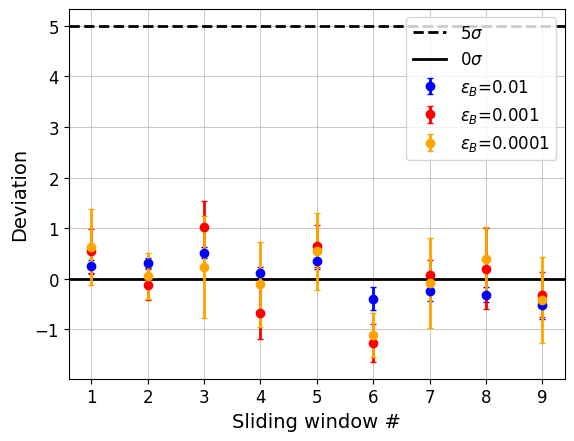

In [8]:
folder = general_directory+"cwola_herwig_extended1_without/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True)
cwola_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=np.mean(rel_error,axis=(1,2)))
plotting(rel_results, true_results, "cwola_herwig_extended1_without")
print("alpha =",cwola_error)

/hpcwork/zu992399/bumphunt_paper/cwola_herwig_extended2_without/
/hpcwork/zu992399/bumphunt_paper/cwola_herwig_extended2_without/
alpha = [0.14247697 0.14341897 0.11096423]


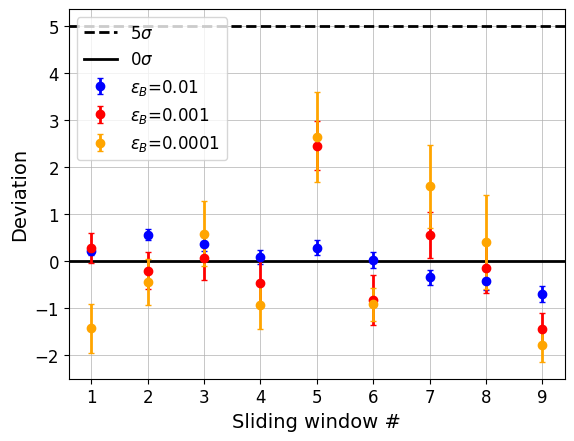

In [9]:
folder = general_directory+"cwola_herwig_extended2_without/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True)
cwola_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=np.mean(rel_error,axis=(1,2)))
plotting(rel_results, true_results, "cwola_herwig_extended2_without")
print("alpha =",cwola_error)

/hpcwork/zu992399/bumphunt_paper/cwola_herwig_extended3_without/
/hpcwork/zu992399/bumphunt_paper/cwola_herwig_extended3_without/
alpha = [ 0.22136169  0.13517264 -0.01469378]


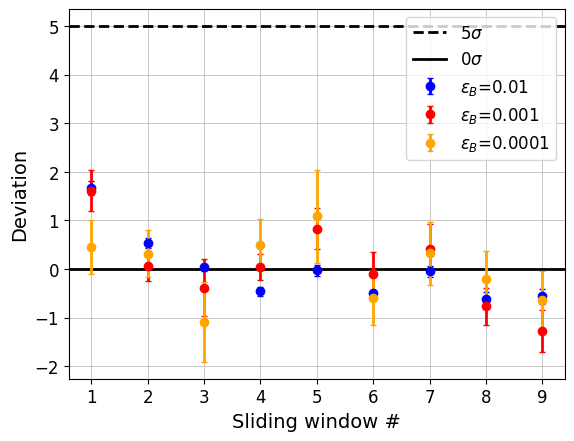

In [7]:
folder = general_directory+"cwola_herwig_extended3_without/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True)
cwola_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=np.mean(rel_error,axis=(1,2)))
plotting(rel_results, true_results, "cwola_herwig_extended3_without")
print("alpha =",cwola_error)

In [10]:
folder = general_directory+"cwola_herwig_without_DR_2/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True)
cwola_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=np.mean(rel_error,axis=(1,2)))
plotting(rel_results, true_results, "cwola_herwig_DR_without")
print("alpha =",cwola_error)

/hpcwork/zu992399/bumphunt_paper/cwola_herwig_without_DR_2/


FileNotFoundError: [Errno 2] No such file or directory: '/hpcwork/zu992399/bumphunt_paper/cwola_herwig_without_DR_2/window1_fold0/samples_preds.npy'

# CATHODE Ranit

In [7]:
folder = general_directory+"cathode_extended1_without_ranit_full/"
results, rel_results, true_results, rel_error = bump_hunt(folder, False)
cwola_error = np.mean(rel_error,axis=(1,2))
results, rel_results, true_results, rel_error = bump_hunt(folder, False, err=np.mean(rel_error,axis=(1,2)))
plotting(rel_results, true_results, "cathode_extended1_without_ranit")
print("alpha =",cwola_error)

/hpcwork/zu992399/bumphunt_paper/cathode_extended1_without_ranit_full/


FileNotFoundError: [Errno 2] No such file or directory: '/hpcwork/zu992399/bumphunt_paper/cathode_extended1_without_ranit_full/window1_fold0/samples_preds.npy'